In [1]:
using DifferentialEquations, Plots, CSV, DataFrames, Dates

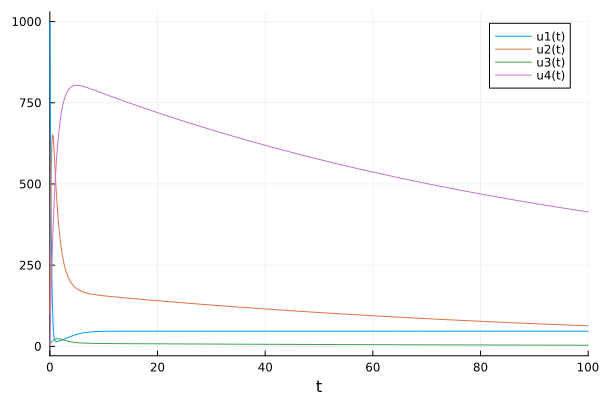

In [2]:
function SEIRS(du, u, p, t)
    S,E,I,R = u
    β, ω, γ_r, γ_i, ρ, σ = p

    du[1] = (-β * S * I) - ω*S + γ_r * R
    du[2] = (β * S * I)- σ*E - ω*E
    du[3] = (σ * ρ * E) - (γ_i * I) - (ω * I)
    du[4] = (γ_i * I) - (γ_r * R) + ω * (S+E+I)
end

p = [0.3, 0.7, 0.2,0.2, 0.5, 0.1]

init = [1000,100, 10 ,1]
tspan = (0.0, 100.0)

prob = ODEProblem(SEIRS, init, tspan, p)

sol = solve(prob, Tsit5())

plot(sol)

SEIRS (generic function with 1 method)

In [4]:
url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"

download(url, "covid_data.csv")

"covid_data.csv"

In [5]:
function data_processing(country)
    data = CSV.read("covid_data.csv", DataFrame)
    rename!(data, 1 => "province", 2 => "country")
    countries = collect(data[:, 2])
    row = findfirst(countries .== country)
    data_row = data[row, :]
    country_data = [i for i in values(data_row[5:end])]

    date_strings =String.(names(data))[5:end]

    format = Dates.DateFormat("m/d/Y")
    dates = parse.(Date, date_strings, format) + Year(2000)

    return country_data
end

data_processing (generic function with 1 method)

In [ ]:
date_strings =String.(names(data))[5:end]

format = Dates.DateFormat("m/d/Y")
dates = parse.(Date, date_strings, format) + Year(2000)

In [6]:
ng_data = data_processing("Nigeria")

1050-element Vector{Int64}:
      0
      0
      0
      0
      0
      0
      0
      0
      0
      0
      ⋮
 266283
 266283
 266283
 266283
 266283
 266283
 266283
 266283
 266283

In [8]:
df = ng_data[1:100]

100-element Vector{Int64}:
    0
    0
    0
    0
    0
    0
    0
    0
    0
    0
    ⋮
  873
  981
 1095
 1182
 1273
 1337
 1532
 1728
 1932

In [9]:
function SEIRS(du, u, p, t)
    S,E,I,R = u
    β, ω, γ_r, γ_i, ρ, σ = p

    du[1] = (-β * S * I) - ω*S + γ_r * R
    du[2] = (β * S * I)- σ*E - ω*E
    du[3] = (σ * ρ * E) - (γ_i * I) - (ω * I)
    du[4] = (γ_i * I) - (γ_r * R) + ω * (S+E+I)
end


SEIRS (generic function with 1 method)

In [15]:
u0 = [2*10^5; 1000; 10; 1 ]
tspan = (0.0, 100.0)

(0.0, 100.0)

In [16]:
model_ode(p_) = ODEProblem(SEIRS, u0, tspan, p_)

model_ode (generic function with 1 method)

In [17]:
loss_objective(mp_, dat) = build_loss_objective(model_ode(mp_), Tsit5(), L2Loss(t,dat))

loss_objective (generic function with 1 method)

In [30]:
using JuMP, NLopt, HiGHS
juobj(args...) = loss_objective(args, df)(args)
jumodel = Model()
JuMP.register(jumodel, :juobj, 6, juobj, autodiff=true)
@variables jumodel begin
    β,(start=8)
    ω,(start=25.0)
    γ_r,(start=10/3)
    γ_i,(start= 0.01)
    ρ,(start=0.01)
    σ,(start=0.02)
end
@NLobjective(jumodel, Min, juobj(β, ω, γ_r, γ_i, ρ, σ))
setsolver(jumodel, NLoptSolver(algorithm=:LD_MMA))

UndefVarError: UndefVarError: setsolver not defined

In [29]:
sol = JuMP.solve(jumodel)
best_mp = getvalue.(getindex.((jumodel,), Symbol.(jumodel.colNames)))

UndefVarError: UndefVarError: solve not defined

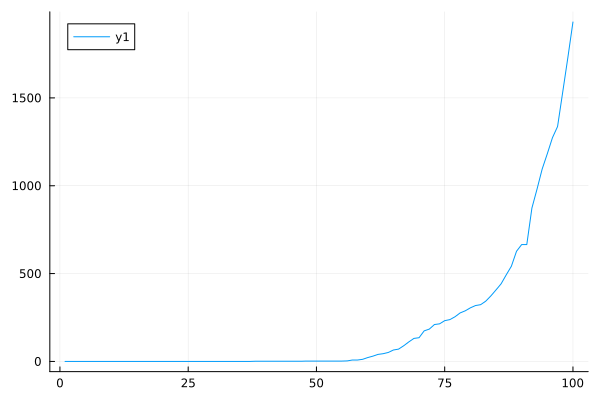

In [10]:
plot(df)